# Identify stars in images

The star catalog **hip_main.dat** consists of columns separated by | and with no header. Column 2 is the star identifier, column 6 is the magnitude, column 9 and 10 are RA and DE in degrees.

In [30]:
%matplotlib inline

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [32]:
import simulator as sim
import os

In [33]:
star_catalog = sim.StarCatalog('../data/hip_main.dat')

In [34]:
len(star_catalog.star_vectors)

117955

In [35]:
np.min(star_catalog.magnitudes)

-1.4399999999999999

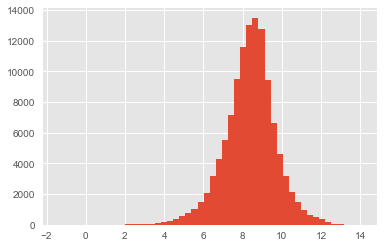

In [36]:
pd.Series(star_catalog.magnitudes).hist(bins=50)

The function *calc_md5* is used to calculate a MD5 checksum from the star catalog to detect changes of the file. In this case the features have to be recalculated.

In [37]:
from hashlib import md5

def calc_md5(file_name):
    "Calculates the MD5 checksum of a file content"
    fd = open(file_name)
    buffer = fd.read()
    hash = md5(buffer)
    fd.close()
    return hash.hexdigest()

In [38]:
def distance(v):
    return np.sqrt(np.dot(v,v))

def make_zero_if_negative(x):
    "Negative values are mapped to zero"
    return x if x > 0 else 0

def get_key(mag1,mag2,normalized_angle,distance_ratio):
    "Generates an integer key based on parameters of two neighbouring stars"
    # a magnitude smaller than 0 is mapped to zero
    key1 = '{:d}'.format(int(np.rint(make_zero_if_negative(mag1))))
    key2 = '{:d}'.format(int(np.rint(make_zero_if_negative(mag2))))
    key3 = '{:d}'.format(int(np.rint(normalized_angle * 10.0)))
    key4 = '{:d}'.format(int(np.rint(distance_ratio * 10.0)))
    return int(key1 + key2 + key3 + key4)
    
def get_parameters(hips,relpos,relmag,distances):
    "Calculate the parameters for the nearest stars"
    param = list()
    n = len(distances)
    if hips != None:
        param.extend(hips)
    param.extend(relmag)
    key = np.nan
    for index in range(n-1):
        d1 = distances[index]
        d2 = distances[index+1]
        v1 = relpos[index]
        v2 = relpos[index+1]
        cosalpha = np.dot(v1,v2)/(d1*d2)
        if np.abs(cosalpha) > 1.0:
            cosalpha = min(1.0, cosalpha)
            cosalpha = max(-1.0, cosalpha)
        normalized_angle = np.arccos(cosalpha)/np.pi
        param.append(normalized_angle)
        v = d2/d1 # value is always >= 1, because stars are ordered by their relative distance
        param.append(v)
        if index == 0:
            key = get_key(relmag[0],relmag[1],normalized_angle, v)
    param.append(key)
    return np.array(param)

def get_columns(n):
    "Get the columns names of all features"
    cols = []
    for i in range(n):
        cols.append('hip' + str(i+1))
    for i in range(n):
        cols.append('relative_magnitude' + str(i+1))
    if n > 1:
        for i in range(n-1):
            s = str(i+1) + str(i+2)
            cols.append('normalized_angle' + s)
            cols.append('relative_distance_ratio' + s)
    cols.append('key')
    return cols

def get_nearest_stars(ids, dist, n=1):
    "Get the n nearest stars"
    stars = []
    num_stars = min(n,len(dist))
    selection = np.array([True]*len(dist))
    while len(stars) < num_stars:
        index = np.argmin(dist[selection])
        identifier = ids[selection][index]
        stars.append(identifier)
        selection[ids == identifier] = False
    return stars

Calculate all the features based on **hip_main.dat**, which are used for classification

In [39]:
# check first if the features have been already calculated
signature = calc_md5('../data/hip_main.dat')

filename = '../data/hip_feat_' + str(signature) + '.csv'
if os.path.exists(filename):
    
    features = pd.read_csv(filename, index_col = 0)

else:

    # find the N closest stars to each star in the catalog
    N = 5
    ids = star_catalog.catalog['HIP'].values
    star_catalog.catalog.index = ids
    cat = zip(ids, star_catalog.star_vectors,star_catalog.magnitudes)
    features = pd.DataFrame(index = ids, 
                            columns = get_columns(N))

    for hip, pos, mag in cat:

        # get the nearest star
        selection = ids != hip
        dist = star_catalog.star_vectors[selection] - pos
        dist2 = np.sum(dist * dist, axis=1)
        nearest_stars = get_nearest_stars(ids[selection],dist2,n=N)
        
        hips = []
        relpos = []
        relmag = []
        distances = []
        for identifier in nearest_stars:
            index = np.where(ids[selection] == identifier)[0][0]
            hips.append(identifier)
            relpos.append(dist[index])
            relmag.append(star_catalog.magnitudes[selection][index] - mag)
            distances.append(np.sqrt(dist2[index]))

        # calculate star measures
        features.ix[hip] = get_parameters(hips, relpos, relmag, distances)


    features.to_csv(filename)

In [40]:
features['key'] = features['key'].astype(np.int)

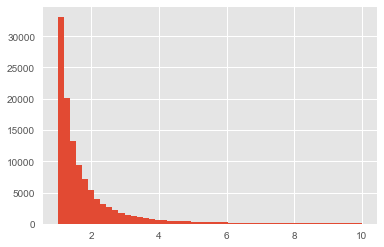

In [41]:
features['relative_distance_ratio12'][np.abs(features['relative_distance_ratio12']) < 10].hist(bins=50)

In [42]:
def get_data(filename, reshape=True, dtype = np.float):
    fd = open(filename,'r')
    lines = fd.readlines()
    fd.close()
    data = []
    for line in lines:
        arr = np.array(line.split(','),dtype = dtype)
        if reshape:
            arr = arr.reshape([len(arr) // 3, 3])
        data.append(arr)
    return data

There are the following cases in the star identification:

- the star can be a false star
- the star is a real star, but there are false stars in the neigbourhood

In [45]:
def identify_stars(scene, features):
    "Identifies all stars in the scene including false stars"
    count,length = scene.shape
    selection = np.array([True] * count)
    stars = np.zeros(count,dtype=np.int)
    found = 0
    # find the point in the scene, which is closest to the center
    m = np.mean(scene[:,0:2], axis=1)
    x = scene[:,0] - m[0]
    y = scene[:,1] - m[1]
    dist2 = x*x + y*y
    # identify at most 2 stars in a scene
    while found < 2 and not np.all(selection == False):
        index = np.argmin(dist2)
        selection[index] = False
        dist2[index] = np.inf
        others = scene[selection,:] - scene[index,:]
        hip = classify_star(others, features)
        if hip > 0:
            stars[index] = hip
            found = found + 1
    # if 2 stars have been identified, identify remaining stars as known or false
    if found > 1:
        # check if the distance between the two stars matches with the distance in the scene
        pass
    
    stars[stars == 0] = -1
    return stars

def classify_star(others, features):
    "Searches the features array for a matching star"
    x = others[:,0]
    y = others[:,1]
    dist2 = x*x + y*y
    ids = np.arange(len(x))
    nearest_stars = get_nearest_stars(ids,dist2,n=5)
      
    relpos = []
    relmag = []
    distances = []
    for index in nearest_stars:
        relpos.append(others[index,0:2])
        relmag.append(others[index,2])
        distances.append(np.sqrt(dist2[index]))
        
    params = get_parameters(None,relpos,relmag,distances)
    key = params[-1]
    # key can be NaN
    found = features[features['key'] == key]
    return len(found) > 0

In [46]:
# scenes = get_data('../data/input.csv')
scenes = get_data('../example/input_sample.csv')
results = get_data('../example/result_sample.csv', reshape=False, dtype=np.int)
for scene,result in zip(scenes,results):
    stars = identify_stars(scene, features)
    print stars
    print result

[-1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1]
[   -1    -1 29730    -1    -1 27971 27949 29246    -1 25197 24914    -1
 28358    -1]
[-1 -1 -1  1  1 -1 -1 -1]
[   -1    -1 93148    -1    -1 93815 92646    -1]
[-1 -1 -1 -1 -1 -1  1  1]
[44901 47006    -1 46853 42372 45493 44127 44613]
[ 1  1 -1 -1 -1 -1 -1 -1 -1]
[    -1     -1 115404 116957 116758 116971     -1 115126     -1]
[ 1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1]
[101847 103569 101936     -1 103571 101692     -1 102633     -1     -1
     -1]
[-1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1]
[32349    -1 33302 31700 33316    -1 33092 33347 35180    -1    -1 33077
    -1    -1 34045    -1]
[ 1 -1 -1 -1 -1  1]
[32765 34081 31765 34065 31685 33357]
[-1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
[   -1 88192 85749 88149    -1    -1    -1 87108    -1    -1 85537 86742]
[ 1  1 -1 -1 -1 -1 -1 -1 -1 -1]
[   -1    -1 23900    -1 25695 24822 23497    -1 23871    -1]
[ 1 -1 -1  1 -1 -1 -1 -1 -1 -1]
[   -1    -1    -1    -1    -1 69673    -1 69226    -1 70602]
[